# Leaf segmentation and tracking prediction pipeline

### Intro
This notebook shows how to run instance segmentation on plant images using the pretrained detectron2 model.

The segmentation results are saved as two instance masks, one for the central plant and one for the central plant’s leaves. In both masks, each instance has a different pixel value.

Each leaf instance will have a value corresponding to the same leaf on the other video frames for tracking.

For plant, leaves, and tracking, there is a visualization image saved, stored in the Visualization folder.

# Installation for Google Colab

In [2]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import distutils.core
import os
import sys
!pip install torch==2.2.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
!python -m pip install pyyaml
!python -m pip install laptrack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.3 MB/s eta 0:00:00
Cloning into 'detectr

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=3ca76760a8fb21179ec63b7220dede3b87a6159c471d518ca4bb65b4c355985d
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=bc3eabe3bc8429d52de153f32acb460197fbfb2043d66d52cb30979e4241a559
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a12

In [4]:
!python -m pip uninstall numpy -y
!python -m pip install numpy==1.24.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
laptrack 0.16.1 requires numpy<2.0,>=1.26; python_version >= "3.9", but you have numpy 1.24.4 which is incompatible.


# Imports

In [5]:
import distutils.core
import os
import sys
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [6]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from pathlib import Path
import imageio.v2 as imageio
import pandas as pd
from tqdm import tqdm
from skimage.color import label2rgb
from skimage.measure import regionprops_table
from skimage.transform import rescale
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from laptrack import LapTrack
import numpy as np

# Main functions for prediction

In [7]:
# load model, set prediction score threshold
def load_model(weights: str, device: str='cpu', score_threshold: float=0.75):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATALOADER.NUM_WORKERS = 1
    cfg.MODEL.WEIGHTS = weights
    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    cfg.MODEL.WEIGHTS = weights
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_threshold   # set a custom testing threshold
    cfg.MODEL.DEVICE = device
    predictor = DefaultPredictor(cfg)
    return predictor


# if there are several plants predicted, leave only the central one
def find_central_plant_mask(plant_boxes: np.ndarray, plant_masks: np.ndarray):
    image_height, image_width = plant_masks.shape[1:]
    image_center = np.array([image_height / 2, image_width / 2])

    plant_centers = []
    for box in plant_boxes:
        l, t, r, b = box
        height = b - t
        width = r - l
        plant_centers.append((height // 2, width // 2))

    plant_centers = np.array(plant_centers)

    distance = np.linalg.norm(plant_centers - image_center, axis=1)
    best_plant_index = np.argmin(distance)
    central_plant_mask = plant_masks[best_plant_index]
    central_plant_mask = central_plant_mask.astype(np.uint8)

    return central_plant_mask


# read image and scale it down
def prepare_image(image_path: Path, result_path: Path, scale_factor: float=0.5):
    image = imageio.imread(image_path, pilmode='RGB')
    image = rescale(image, (scale_factor, scale_factor, 1))
    image = (image * 255).astype(np.uint8)
    imageio.imwrite(result_path / ('scaled_' + image_path.name), image)
    return image


# leave only leaves that belong to the central plant
def remove_other_plants(leaf_masks: np.ndarray, central_plant_mask: np.ndarray, min_overlap: float=0.5):
    central_plant_leaves_mask = []
    for leaf_mask in leaf_masks:
      intersection = np.sum(central_plant_mask * leaf_mask)
      leaf_area = np.sum(leaf_mask)
      overlap = intersection / leaf_area
      if overlap > min_overlap:
        central_plant_leaves_mask.append(leaf_mask)
    central_plant_leaves_mask = np.array(central_plant_leaves_mask)
    return central_plant_leaves_mask


# covert a set of instance masks to a sinle mask
def instance_masks_to_mask(instance_mask: np.ndarray):
    mask_labels = np.arange(instance_mask.shape[0])
    mask_labels = mask_labels[..., None, None]
    mask_labels = mask_labels + 1
    result_mask = np.max(instance_mask * mask_labels, axis=0)
    result_mask = result_mask.astype(np.uint8)
    return result_mask


# run prediction and save the result
def predict_single_image(image_path: Path, result_path: Path, predictor, visualize=True):
    # Prepare image for prediction
    image = prepare_image(image_path, result_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Execute prediction
    predictions = predictor(image)
    instances = predictions["instances"].to("cpu")

    # Get masks from predictions
    leaf_masks, plant_masks = [], []
    plant_boxes = []
    for box, score, label, mask in zip(
        instances.pred_boxes, instances.scores, instances.pred_classes, instances.pred_masks
    ):
        mask = mask.numpy()
        if label == 0:
            plant_masks.append(mask)
            plant_boxes.append(box)
        else:
            leaf_masks.append(mask)

    leaf_masks = np.array(leaf_masks)
    plant_masks = np.array(plant_masks)

    if leaf_masks.size == 0:
      print(f'No leaves predicted for image: {image_path}!')
      return

    # Find central plant
    central_plant_mask = find_central_plant_mask(plant_boxes, plant_masks)
    # Leave only central plant's leaves
    central_plant_leaves = remove_other_plants(leaf_masks, central_plant_mask)
    # Convert leaf masks to a single mask
    leaf_mask = instance_masks_to_mask(instance_mask=central_plant_leaves)

    # Save images
    imageio.imsave(result_path / ('leaf_' + image_path.name), leaf_mask)
    imageio.imsave(result_path / ('plant_' + image_path.name), central_plant_mask)

    # Save visualization
    if visualize:
      (result_path / 'visualize').mkdir(exist_ok=True)

      vis_image_leaf = label2rgb(leaf_mask, image=image)
      vis_image_leaf = (vis_image_leaf * 255).astype(np.uint8)

      vis_image_plant = label2rgb(central_plant_mask, image=image)
      vis_image_plant = (vis_image_plant * 255).astype(np.uint8)

      imageio.imsave(result_path / 'visualize' / ('vis_leaf_' + image_path.name), vis_image_leaf)
      imageio.imsave(result_path / 'visualize' / ('vis_plant_' + image_path.name), vis_image_plant)

## Load the model and set the prediction threshold

In [8]:
# Load model and set the score threshold
predictor = load_model(
    weights="/content/oc-1-project-74/resources/trained_models/model.pth",
    device='cpu',
    score_threshold=0.5
)

[03/18 21:14:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/oc-1-project-74/resources/trained_models/model.pth ...


## Run predictions

In [9]:
# Select image folder
image_path = Path('/content/drive/MyDrive/leaf segm demo/set_522_bra/')

# Find all images in the folder and sort them by day
images = sorted(image_path.glob('*.png'), key=lambda x: int(x.name.split('-')[1]))

# Create an output folder
result_path = Path(image_path / 'prediction/')
result_path.mkdir(exist_ok=True)

# Run predictions on all images in the folder, save results into "prediction" folder
for image_path in tqdm(images):
  predict_single_image(image_path, result_path, predictor=predictor, visualize=True)

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 11/11 [05:35<00:00, 30.50s/it]


# Visualize result on one image

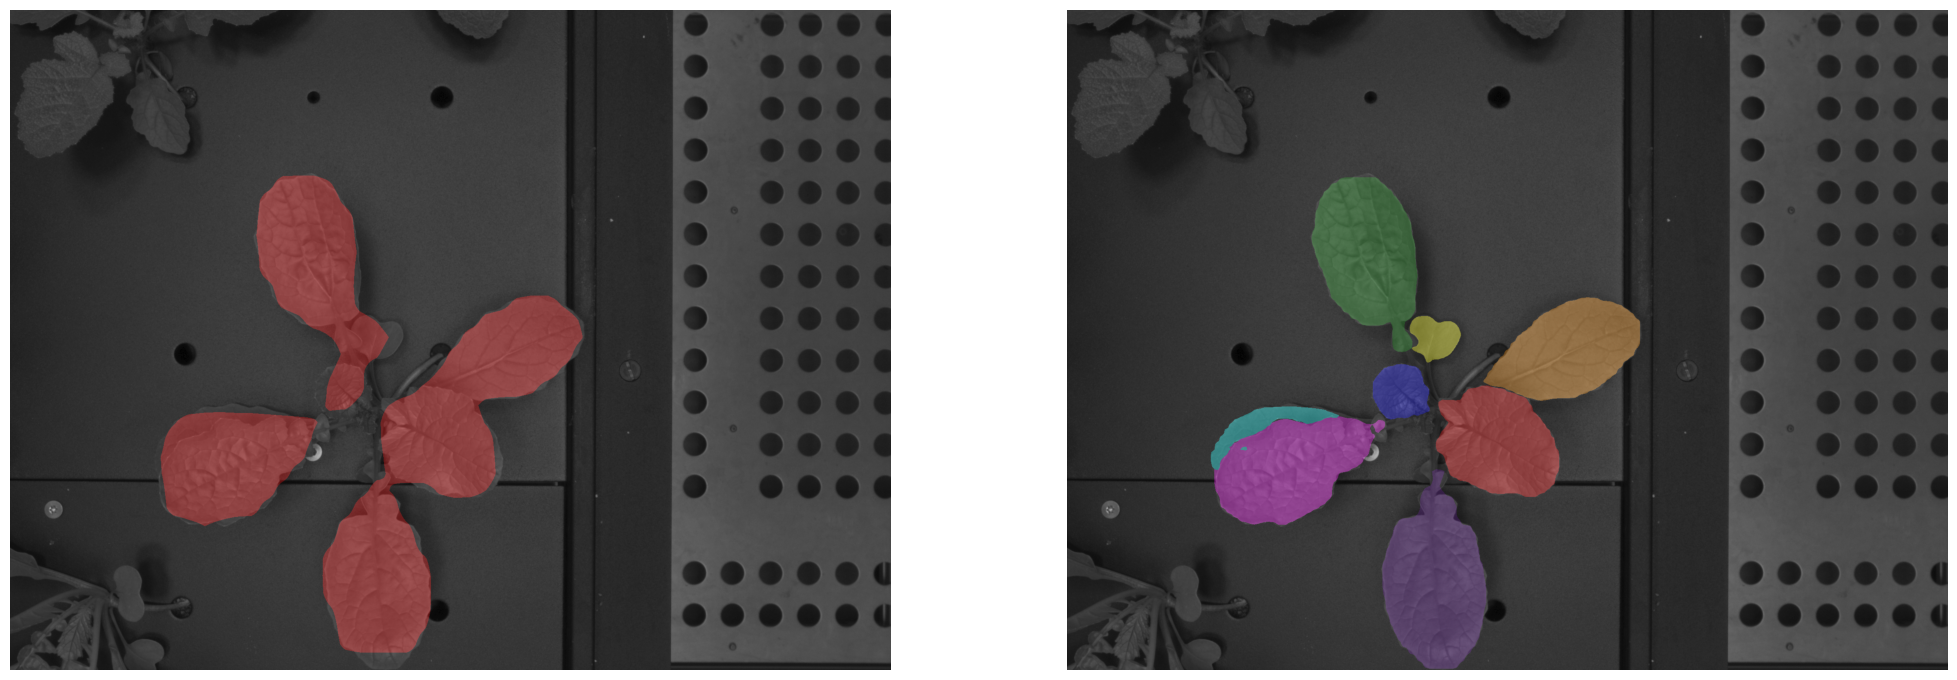

In [10]:
plant_result = imageio.imread(result_path / 'visualize' / ('vis_plant_' + images[-1].name))
leaf_result = imageio.imread(result_path / 'visualize' / ('vis_leaf_' + images[-1].name))

plt.figure(figsize=(25, 25))
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(plant_result)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(leaf_result)

# Main functions and parameters for tracking

In [11]:
# Maximum distance in pixels that the leaf centroid is allowed to travel between frames
MAX_DISTANCE = 1000

# Create a custom colormap for tracks visualization
def create_colormap(n_colors: int, base_colormap: str='Set1'):
  colormap = plt.get_cmap(base_colormap)
  colors = ['black'] + [colormap(color) for color in range(n_colors)]
  custom_cmap = LinearSegmentedColormap.from_list(
      "custom_cmap", colors, N=n_colors + 1
  )
  return custom_cmap


# Calculate properties of the leaf masks
def create_properties_data(mask_paths):
  print('Calculating region properties')
  regionprops = []
  for i, mask_path in enumerate(tqdm(mask_paths)):
      mask = imageio.imread(mask_path)
      df = pd.DataFrame(
          regionprops_table(
              mask,
              properties=['centroid', 'orientation', 'area', 'label']
          )
      )
      df["frame"] = i
      regionprops.append(df)
  regionprops_df = pd.concat(regionprops)
  return regionprops_df


# Execute tracking prediction
def predict_tracking_df(props_df, max_distance=MAX_DISTANCE):
  lt = LapTrack(
      track_dist_metric="sqeuclidean",
      track_cost_cutoff=max_distance**2,
      gap_closing_cost_cutoff=max_distance**2,
      splitting_cost_cutoff=False,
      merging_cost_cutoff=False,
  )

  predict_df = props_df.copy().drop('label', axis=1)
  result_df, _, _ = lt.predict_dataframe(
      predict_df,
      coordinate_cols=["centroid-0", "centroid-1"],
      only_coordinate_cols=False,
  )
  result_df = result_df.reset_index()
  result_df = result_df.combine_first(props_df.reset_index(drop=True))
  return result_df


def predict_tracks(images: np.ndarray, leaf_masks: np.ndarray, result_path: Path, visualize=True):
    props_df = create_properties_data(leaf_masks)
    track_df = predict_tracking_df(props_df, max_distance=MAX_DISTANCE)

    print('Predicting tracking')
    tracking_masks = []
    for i, mask_path in enumerate(tqdm(leaf_masks)):
        mask = imageio.imread(mask_path)
        tracking_mask = np.zeros_like(mask)
        for i, row in track_df[track_df.frame == i].iterrows():
            label = row['label']
            track = int(row['track_id']) + 1
            tracking_mask[mask == label] = track
        imageio.imsave(result_path / ('tracking_' + mask_path.name), tracking_mask)
        tracking_masks.append(tracking_mask)

    if visualize:
        print('Creating visualizations')
        vis_images = []
        for image_path, mask in tqdm(zip(images, tracking_masks), total=len(images)):
            image = imageio.imread(result_path / ('scaled_' + image_path.name))
            colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

            for label in np.unique(mask):
                if label > 0:
                  color = colormap(label)[:-1]
                  color = np.array(color)[None, ...]
                  color = (color * 255).astype(np.uint8)
                  colored_mask[mask == label] = color

            blended_image = cv2.addWeighted(image, 0.8, colored_mask, 0.6, 0)
            imageio.imsave(result_path / 'visualize' / ('vis_tracking_' + image_path.name), blended_image)
            vis_images.append(blended_image)

        imageio.mimsave(result_path / 'visualize' / 'vis_video.mp4', vis_images, fps=1)

In [12]:
# Create a custom colormap to visualize tracks
colormap = create_colormap(20)

# Find all predicted masks and run tracking
leaf_masks = sorted(result_path.glob('leaf*.png'), key=lambda x: int(x.name.split('-')[1]))
days_with_predictions = [leaf_mask.name.split('-')[1] for leaf_mask in leaf_masks]
images = [image for image in images if image.name.split('-')[1] in days_with_predictions]
predict_tracks(images, leaf_masks, result_path)

Calculating region properties


100%|██████████| 11/11 [00:00<00:00, 19.35it/s]


Predicting tracking


100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


Creating visualizations


100%|██████████| 11/11 [00:43<00:00,  3.99s/it]


In [13]:
from IPython.display import Video

Video(result_path / 'visualize/vis_video.mp4', embed=True, width=1000)